state.info_loss# Walkthrough - RBIG

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x32", True)

import numpy as onp
from functools import partial

# library functions

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint
# from rbig_jax.rbig import RBIG
# from rbig_jax.data import get_classic
# from rbig_jax.information.rbig import rbig_init
# from rbig_jax.information.reduction import information_reduction
# from rbig_jax.information.entropy import histogram_entropy
# from rbig_jax.plots.info import plot_total_corr
# from rbig_jax.plots.joint import plot_joint
# from rbig_jax.plots.prob import plot_joint_prob
# from rbig_jax.transforms.gaussian import init_params

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

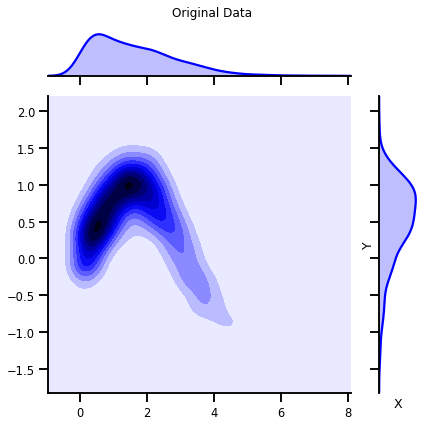

In [2]:
# %%wandb
# get data
data = get_classic(1_000_000)

# plot data
plot_joint(data[:1_000], "blue", "Original Data", kind='kde', logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

## Total Correlation

In [3]:
from rbig_jax.information.entropy import histogram_entropy
from rbig_jax.transforms.histogram import histogram_transform
from rbig_jax.information.total_corr import total_corr_f

In [4]:
# define marginal entropy function
entropy_f = jax.partial(histogram_entropy, nbins=1_000, base=2)

# define marginal uniformization function
hist_transform_f = jax.partial(histogram_transform, nbins=1_000)

In [5]:
%%time
n_iterations = 100

X_trans, loss = total_corr_f(
    np.array(data).block_until_ready(), 
    marginal_uni=hist_transform_f, 
    marginal_entropy=entropy_f, 
    n_iterations=n_iterations
)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


CPU times: user 4.37 s, sys: 90.6 ms, total: 4.46 s
Wall time: 4.44 s


In [6]:
%%time
total_corr = np.sum(loss) * np.log(2)

CPU times: user 380 ms, sys: 23.8 ms, total: 403 ms
Wall time: 86.6 ms


In [7]:
%%time
print(total_corr)

0.7286557143788281
CPU times: user 5min 40s, sys: 10min 7s, total: 15min 48s
Wall time: 56.4 s


#### Plot Latent Space

In [8]:
%%time

X_plot = onp.array(X_trans)

CPU times: user 6.68 ms, sys: 7.54 ms, total: 14.2 ms
Wall time: 12.5 ms


<Figure size 432x288 with 0 Axes>

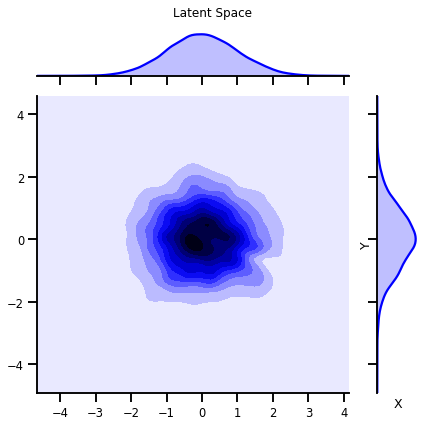

In [9]:
# plot data
plot_joint(
    X_plot[:10_000], 
    "blue", "Latent Space", kind='kde', logger=False
)

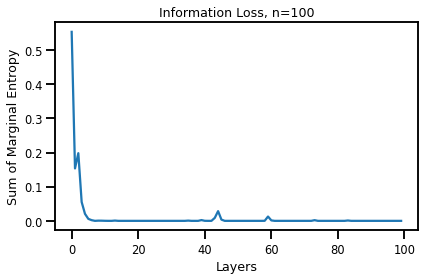

In [10]:
plot_info_loss(loss, n_layers=len(loss))